In [ ]:
# TODO: move functions elsewhere
# TODO: plotfunctions shouldn't call back to the model -- sloppy. want more self contained code.

In [148]:
import sys

sys.path.append("/Users/octavia/Dropbox/SVE_v2/utilities")
sys.path.append("/Users/octavia/Dropbox/SVE_v2/model")

my_modules = ['plot_functions', 'load_model_output', 
              'search_functions', 'plot_3D_functions']
for mod in my_modules:
    if mod in sys.modules:
        print (mod)
        del sys.modules[mod]

import ipywidgets as widgets

from search_functions import *
from load_model_output import *
from plot_functions import *
from plot_3D_functions import *



plot_functions
load_model_output
search_functions
plot_3D_functions


In [149]:
project_dir = "/Users/octavia/Dropbox/SVE_v2/"
base_name = "test_inflow_dx"
base_dir = project_dir  + 'model_output/' + base_name 

print_input_params(base_dir)

batch:
	dx : 0.5, 1.0
sim:
	q1_m2hr : 0.5, 1.0, 1.5, 3
	So : 0.01, 0.1
common:
	H_i : 0.0


In [150]:
core = load_sims(base_dir)

In [151]:
def get_name_vars(base_dir):
    all_params = load_all_params(base_dir)
    batch_vars = [key for key, val in all_params['batch_dict'].items() if len(val) > 1]
    sim_vars = [key for key, val in all_params['sim_dict'].items() if len(val) > 1]

    name_vars = batch_vars + sim_vars
    return name_vars


def get_name_tuples(core):
    
    names = []
    for key in core.index:
        sim = core.loc[key]
        name = ", ".join([ "{0}={1}".format(name_var, sim[name_var]) for name_var in name_vars])
        names.append((name, key))
    return names   

name_vars = get_name_vars(base_dir)

for key in core.index:
    sim = core.loc[key]
    name = ", ".join([ "{0}={1}".format(name_var, sim[name_var]) for name_var in name_vars])
    core.loc[key, "pretty"] = name
    
    
names = get_name_tuples(core)
select_key = widgets.Dropdown(
        options=names,
        description='Name:')

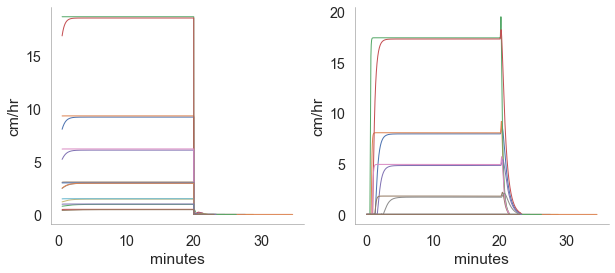

In [152]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))
fig = plot_inflowgraphs(core, trim = 30, nonzero = True, ax= axes[0])
fig = plot_hydrographs(core, nonzero = True, ax = axes[1])


In [157]:
def plot_matched_hydrographs(core, match_var = "dt_sw", ):
    """
    Usage:
        fig1, fig2 = plot_matched_hydrographs(core)
    """
    match_vals = np.unique(core[match_var])
    match_to = match_vals[0]

    subset = core[core[match_var] == match_to]

    num_col = min(4, len(subset))
    num_row = int(np.ceil(len(subset) / 1. / num_col))

    figsize = (num_col * 4, num_row * 2.2)
    fig, axes = plt.subplots(num_row, num_col, figsize=figsize, sharey = True)
    plt.subplots_adjust(hspace=0.2)
    axes = axes.ravel()

    fig2, axes2 = plt.subplots(num_row, num_col,
        figsize=figsize, sharey = True)
    plt.subplots_adjust(hspace=0.2)
    axes2 = axes2.ravel()

    for i, ax in enumerate(axes[:len(subset)]):
        ax2 = axes2[i]
        key = subset.index[i]
        sim = subset.loc[key]
        ax.plot(sim.t_h/60., sim.flux3*3.6e5/sim.nrow,
                label = "{0} = {1}".format(match_var, sim[match_var]))
        ax.set_xlabel("min")

        for other_val in match_vals[1:]:

            params = extract_params(sim)
            params[match_var] = other_val
            matched_sim = filter_core(core, params).iloc[0]
            ax.plot(matched_sim.t_h/60, matched_sim.flux3*3.6e5/matched_sim.nrow,
                label = "{0} = {1}".format(match_var, matched_sim[match_var]))

            tf = min(len(sim.flux3), len(matched_sim.flux3))
            ax2.plot(sim.t_h[:tf]/60,
                     (sim.flux3[:tf]/sim.ncol -
                      matched_sim.flux3[:tf]/matched_sim.ncol)*3.6e5,
                     label = "{0} = {1}".format(match_var, matched_sim[match_var]))

    for i, ax in enumerate(axes[len(subset):]):
        ax.set_visible(False)

    for i, ax2 in enumerate(axes2[len(subset):]):
        ax2.set_visible(False)

    axes[0].set_ylabel("cm/hr")
    axes[4].set_ylabel("cm/hr") if len(subset) > 4 else 0
    axes2[0].set_ylabel("cm/hr")
    axes2[4].set_ylabel("cm/hr") if len(subset) > 4 else 0

    axes[0].legend()
    axes2[0].legend()
    return fig, fig2


def extract_params(sim):
    """
    Return sim parameters in a dictionary

    Note:
        DO not include flags
        TODO: ADD a list of "ignore" fields
        Make this a hydrograph specific function for model / utility independence
    """
    keys = ['q1_m2hr', 'Ks', 'dt_sw', 'tr', 'p', 'tmax_scale', 'dt_print',
            'save_fluxes', 'save_sve', 'dx',
            'veg_type', 'fV', 'grad_fV', 'seed', 'sigma_scale', 'sigma',
            'stripe_count', 'downslope', 'spots',
            'topo', 'So', 'imodel', 's_scale', 'theta_r', 'theta_s',
            'theta_i', 'H_i', 'Ao', 'scheme', 'alpha', 'alphaB',
            'itype1', 'itype3', 'itype2', 'itype4',  'epsh']
    params = {}
    for key in keys:
        if key in sim.keys():
            params[key] = sim[key]
    return params

In [160]:
sim.nrow

25

In [163]:
sim.xc.shape

(25, 8)

(<Figure size 1152x316.8 with 8 Axes>, <Figure size 1152x316.8 with 8 Axes>)

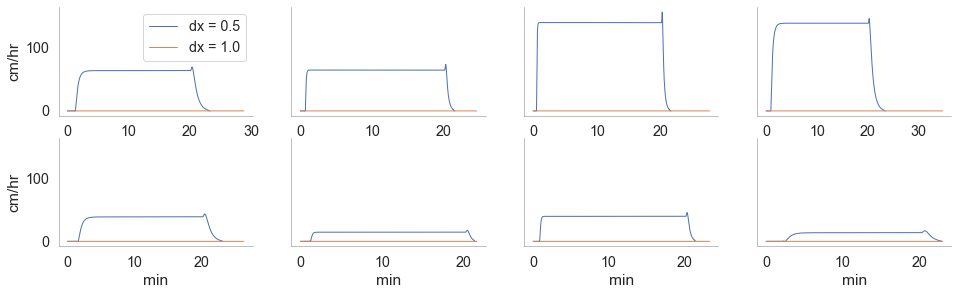

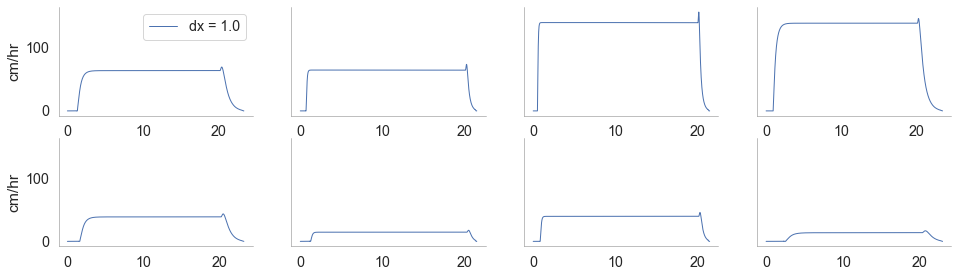

In [164]:
plot_matched_hydrographs(core, "dx")

In [165]:
def summarize_inflow(core):
    core = core.sort_values(["q1_m2hr", "So"], ascending = True)
    
    summary = pd.DataFrame(index = core.index)

    for i,key in enumerate(core.index):
        sim = core.loc[key]
        # input flux m2/s
        q1 = sim.q1

        rain = sim.rain
        f = sim.ksatV

        # Use mass balance to determine how far the wetting front will get
        if sim.ksatV > 0:
            L_max = q1/(sim.ksatV)
        else:
            L_max = np.inf

        summary.loc[key, "L_max"] = L_max

        x_front, t_front = compute_front(sim)
        
        summary.loc[key, "t_10m"] = t_front[int(10/sim.dx)]

        summary.loc[key, "t_20m"] = t_front[int(20/sim.dx)]

        summary.loc[key, "t_end"] = t_front[-1]
        
    

    return summary

# summarize_inflow(core)

In [166]:

display(select_key)

Dropdown(description='Name:', options=(('dx=0.5, q1_m2hr=1.5, So=0.01', 'dx-0.5/So-0.01,q1_m2hr-1.5/'), ('dx=0…

In [167]:

key = select_key.value
print(key)
sim = core.loc[key]

dx-0.5/So-0.01,q1_m2hr-1.5/


dx-0.5/So-0.01,q1_m2hr-1.5/


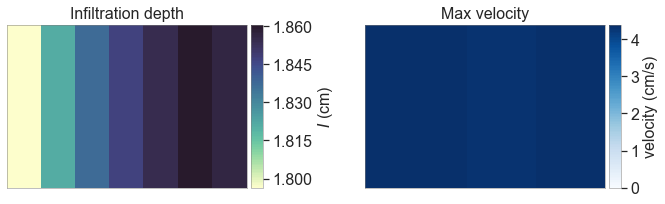

In [168]:

print (sim.name)
fig, axes = triptych(sim);


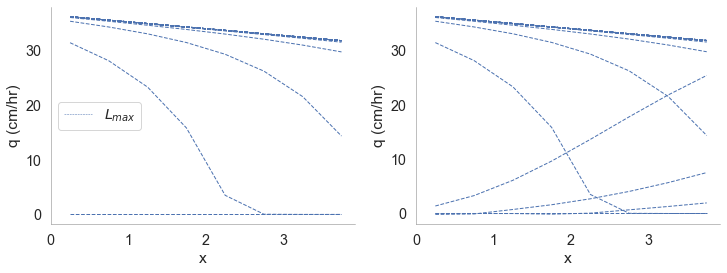

In [169]:
fig,axes = plt.subplots(1, 2, figsize = (12, 4))
fig, ax = plot_all_inflow(sim, t_f = sim.t_rain, freq = 5, label_axes=1, ax = axes[0])
ax.axvline(sim.q1/sim.ksatV, ls = "--", lw = 0.5, label = r"$L_{max}$")
ax.legend()
fig, ax = plot_all_inflow(sim, t_f = sim.t_final, freq = 5, label_axes=1, ax = axes[1])
ax.axvline(sim.q1/sim.ksatV, ls = "--", lw = 0.5, label = r"$L_{max}$")
# plot_inflow(sim, N_profile=6, t_f = sim.t_rain)



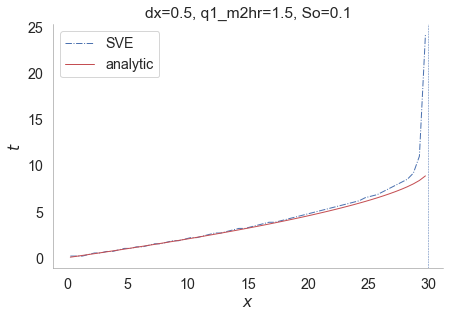

In [133]:
fig, ax  = plt.subplots(1, figsize= (7,4.5))
plt.subplots_adjust(wspace = 0.2)

x_front, t_front = compute_front(sim)
ax.plot(x_front, t_front/60.,'-.',label="SVE")

# x, t = forward_integrate(sim)    
# plt.plot( x, t/60., 'g-', ms = 5, label ="kinematic")
      
d, t = analytic_front(sim)

ax.plot(d, t/60.,'r',lw = 1, label="analytic")    
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_title(sim.pretty)
ax.axvline(sim.q1/sim.ksatV, ls = "--", lw = 0.5, label = r"$L_{max}$")
# ax.set_xlim(15, 20)

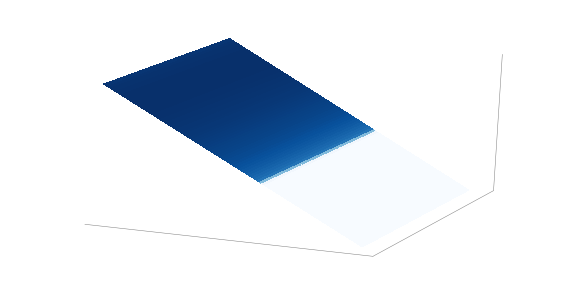

In [134]:
fig = plot_3D_infl(sim)

## Beginnings of analytic approach
Issues : 
1. characteristics cross
2. Combining rain BC (bare soil) with fixed flux (vegetated).  Fixable for constant infiltration rate, but still.

In [61]:
def analytic_front_specify(d, Ly, Q_inflow, KsV = 5, So = 0.01, alpha = 0.1, a= 2/3.):
    """
    Compute position and time for wetting front, using kinematic assumption
    and continuity
    
    Q_inflow : units m2/s
    
    """

    Kr = So**0.5/alpha #

    f = KsV/3.6e5  # Ksat (m/s)
    i =  - f # lateral inputs in m/s


    h_o = (Q_inflow/Kr)**(1./(a+1))


    t = (a+1)*(1/i*(i*d/Kr + Q_inflow/Kr)**(1/(a+1)) - h_o/i)/60.
    return d, t

### Make up some numbers

In [66]:
d = sim.xc.mean(0)
Ly = sim.Ly
So = sim.So
Lb = 20
alpha = sim.alpha
eta = sim.eta
a = sim.m
Kr = sim.So**sim.eta/sim.alpha

In [67]:
## Support, during the rising phase,
rain = 3*3.6e-5 # rain in m/s
t_in = np.arange(0.1, 5, 0.5)*60. # duration in s
q = Kr*rain**(a+1)*t_in**(a+1)

Text(0, 0.5, 't (min)')

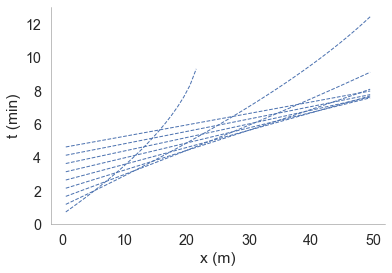

In [69]:
for i, inflow in enumerate(q):
    d, t = analytic_front_specify(d, Ly, inflow, KsV = 5, So = 0.05, alpha = 0.1, a= a)
    plt.plot(d, t + t_in[i]/60., 'b--')
plt.xlabel("x (m)")
plt.ylabel("t (min)")
